# **Mini-Project - I’m Something of a Painter Myself**
Table of Contents:
* [1- Brief Description of the Problem/Data](#brief)
* [2- Load Environment](#environment)
* [3- Exploratory Data Analysis (EDA)](#eda)
* [4- Model Architecture](#model)
* [5- Results and Analysis ](#results)
* [6- Conclusion](#conclusion)
* [7- Submission](#submission)
* [8- Reference](#ref)


<span style="color:red;">(github link)</span>

<a id="brief"></a>
# **1- Brief Description of the Problem/Data**

This dataset and task can be found on [kaggle](https://www.kaggle.com/competitions/gan-getting-started).

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this mini-project, we will bring that style to our photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing we’ve created a true Monet? That’s the challenge we’ll take on!

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our project, we should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Our task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

<a id="environment"></a>
# **2- Load Environment**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import shutil

<a id="eda"></a>
# **3- Exploratory Data Analysis (EDA)** 

In [2]:
# Define the data path
GCS_PATH = "gan-getting-started"

# Get the list of Monet and Photo image files
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))

# Print the number of files found
print('Monet jpg Files:', len(MONET_FILENAMES))
print('Photo jpg Files:', len(PHOTO_FILENAMES))

Monet jpg Files: 300
Photo jpg Files: 7038


Monet image shape: (256, 256, 3)
File path: gan-getting-started\monet_jpg\000c1e3bff.jpg
Photo image shape: (256, 256, 3)
File path: gan-getting-started\photo_jpg\00068bc07f.jpg


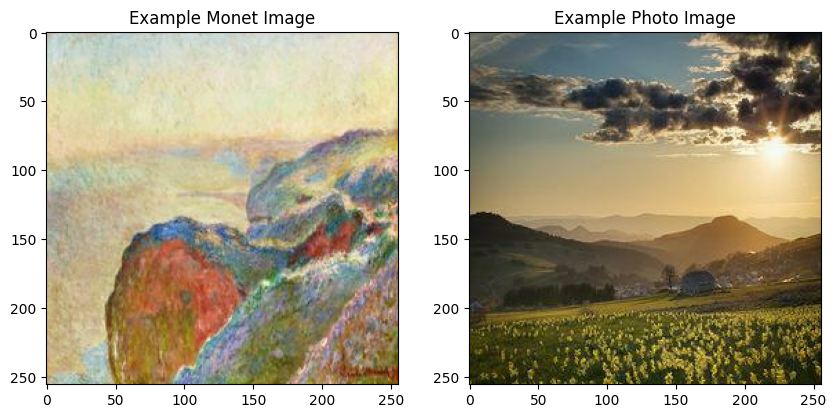

In [3]:
# Load and display an example Monet image & Photo image
if MONET_FILENAMES and PHOTO_FILENAMES:
    example_monet_path = MONET_FILENAMES[0]
    monet_image = tf.io.read_file(example_monet_path)
    monet_image = tf.image.decode_jpeg(monet_image, channels=3)
    print("Monet image shape:", monet_image.shape)
    print("File path:", example_monet_path)

    example_photo_path = PHOTO_FILENAMES[0]
    photo_image = tf.io.read_file(example_photo_path)
    photo_image = tf.image.decode_jpeg(photo_image, channels=3)
    print("Photo image shape:", photo_image.shape)
    print("File path:", example_photo_path)
    
    # Display the images side by side
    plt.figure(figsize=(10, 5)) # Set the figure size

    # Show Monet image in the first subplot
    plt.subplot(1, 2, 2)
    plt.imshow(photo_image.numpy())
    plt.title("Example Photo Image")
    # plt.axis('off')

    # Show Photo image in the second subplot
    plt.subplot(1, 2, 1)
    plt.imshow(monet_image.numpy())
    plt.title("Example Monet Image")
    # plt.axis('off')

    plt.show()


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale.

In [ ]:
IMAGE_SIZE = [256, 256]
def decode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Convert the list of file paths to a TensorFlow dataset where each element is a file path string
monet_ds = tf.data.Dataset.from_tensor_slices(MONET_FILENAMES)
photo_ds = tf.data.Dataset.from_tensor_slices(PHOTO_FILENAMES)

# Apply the preprocessing function with parallelism for training or further processing
monet_ds = monet_ds.map(decode_image,num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(decode_image,num_parallel_calls=tf.data.AUTOTUNE)

# Optimize dataset performance for training (batching, shuffling, prefetching)
BATCH_SIZE = 32  # Define an appropriate batch size

monet_ds = monet_ds.shuffle(buffer_size=len(MONET_FILENAMES)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
photo_ds = photo_ds.shuffle(buffer_size=len(PHOTO_FILENAMES)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Print dataset summary
print(f"Monet dataset batches: {len(MONET_FILENAMES) // BATCH_SIZE}")
print(f"Photo dataset batches: {len(PHOTO_FILENAMES) // BATCH_SIZE}")

Monet dataset batches: 9
Photo dataset batches: 219


<a id="model"></a>
# **4- Model Architecture**

We'll create a CycleGAN model for Monet-style image generation since it is well-suited for style transfer tasks. This type of GAN is particularly effective when we do not have paired datasets of Monet paintings and real-world images.

In [5]:
# Define Generator
def build_generator():
    inputs = Input(shape=(256, 256, 3))
    
    # Downsampling layers
    x = Conv2D(16, (7, 7), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(32, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    # for _ in range(2):
    #     res = Conv2D(32, (3, 3), padding='same')(x)
    #     res = BatchNormalization()(res)
    #     res = ReLU()(res)
    #     res = Conv2D(32, (3, 3), padding='same')(res)
    #     res = BatchNormalization()(res)
    #     x = tf.keras.layers.Add()([x, res])
    
    # Upsampling layers
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return keras.Model(inputs, x, name="Generator")

# Define Discriminator
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(16, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    for filters in [32, 64]:
        x = Conv2D(filters, (4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.2)(x)
    
    x = Conv2D(1, (4, 4), padding='same')(x)
    return keras.Model(inputs, x, name="Discriminator")

In [6]:
# Define loss functions
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Define cycle consistency loss
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

In [7]:
class CycleGAN:
    def __init__(self, learning_rate=0.0002, beta_1=0.5):
        # Initialize models
        self.models = {
            "generator_G": build_generator(),  # Generator: Real photo → Monet-style
            "generator_F": build_generator(),  # Generator: Monet-style → Real photo
            "discriminator_X": build_discriminator(),  # Discriminator: Checks if photo is real
            "discriminator_Y": build_discriminator()  # Discriminator: Checks if Monet painting is real
        }
        
        # Initialize optimizers
        self.optimizers = {
            "gen_G": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
            "gen_F": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
            "disc_X": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
            "disc_Y": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
        }
    
    def train_step(self, real_X, real_Y):
        with tf.GradientTape(persistent=True) as tape:
            fake_Y = self.models["generator_G"](real_X, training=True)
            cycled_X = self.models["generator_F"](fake_Y, training=True)
            
            fake_X = self.models["generator_F"](real_Y, training=True)
            cycled_Y = self.models["generator_G"](fake_X, training=True)
            
            real_output_X = self.models["discriminator_X"](real_X, training=True)
            fake_output_X = self.models["discriminator_X"](fake_X, training=True)
            
            real_output_Y = self.models["discriminator_Y"](real_Y, training=True)
            fake_output_Y = self.models["discriminator_Y"](fake_Y, training=True)
            
            gen_G_loss = generator_loss(fake_output_Y) + cycle_loss(real_X, cycled_X)
            gen_F_loss = generator_loss(fake_output_X) + cycle_loss(real_Y, cycled_Y)
            
            disc_X_loss = discriminator_loss(real_output_X, fake_output_X)
            disc_Y_loss = discriminator_loss(real_output_Y, fake_output_Y)
        
        gradients = {
            "gen_G": tape.gradient(gen_G_loss, self.models["generator_G"].trainable_variables),
            "gen_F": tape.gradient(gen_F_loss, self.models["generator_F"].trainable_variables),
            "disc_X": tape.gradient(disc_X_loss, self.models["discriminator_X"].trainable_variables),
            "disc_Y": tape.gradient(disc_Y_loss, self.models["discriminator_Y"].trainable_variables)
        }
        
        for key, grads in gradients.items():
            valid_grads = [(grad, var) for grad, var in zip(grads, self.models[key.replace("gen_", "generator_").replace("disc_", "discriminator_")].trainable_variables) if grad is not None]
            self.optimizers[key].apply_gradients(valid_grads)
        
        return gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss
    
    def train(self, dataset_X, dataset_Y, epochs):
        for epoch in range(epochs):
            for real_X, real_Y in zip(dataset_X, dataset_Y):
                gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss = self.train_step(real_X, real_Y)
            print(f"Epoch {epoch+1}, Gen G Loss: {gen_G_loss.numpy()}, Gen F Loss: {gen_F_loss.numpy()}, Disc X Loss: {disc_X_loss.numpy()}, Disc Y Loss: {disc_Y_loss.numpy()}")

<a id="results"></a>
# **5- Results and Analysis**

In this section, We will train the model, try to perform hyperparameter tuning and experiment with different architectures for comparison. We will also apply various techniques to enhance training efficiency and model performance, and evaluate the results if we can.

In [ ]:
# Start training
cycle_gan = CycleGAN(learning_rate=0.0002, beta_1=0.5)
cycle_gan.train(photo_ds, monet_ds, epochs=10)

Epoch 1, Gen G Loss: 1.2566735744476318, Gen F Loss: 1.2943377494812012, Disc X Loss: 1.4020426273345947, Disc Y Loss: 1.4254772663116455
Epoch 2, Gen G Loss: 1.1974871158599854, Gen F Loss: 1.2542225122451782, Disc X Loss: 1.3199710845947266, Disc Y Loss: 1.371852993965149
Epoch 3, Gen G Loss: 1.2487848997116089, Gen F Loss: 1.2035236358642578, Disc X Loss: 1.2895891666412354, Disc Y Loss: 1.3222463130950928
Epoch 4, Gen G Loss: 1.2248600721359253, Gen F Loss: 1.2172949314117432, Disc X Loss: 1.290895938873291, Disc Y Loss: 1.3484642505645752
Epoch 5, Gen G Loss: 1.1473102569580078, Gen F Loss: 1.2607097625732422, Disc X Loss: 1.254974603652954, Disc Y Loss: 1.4178266525268555
Epoch 6, Gen G Loss: 1.1313177347183228, Gen F Loss: 1.2110700607299805, Disc X Loss: 1.3451707363128662, Disc Y Loss: 1.378592848777771
Epoch 7, Gen G Loss: 1.1189483404159546, Gen F Loss: 1.1721279621124268, Disc X Loss: 1.2912266254425049, Disc Y Loss: 1.3305494785308838
Epoch 8, Gen G Loss: 1.112012863159179

In [ ]:
# Start training
cycle_gan1 = CycleGAN(learning_rate=0.01, beta_1=0.5)
cycle_gan1.train(photo_ds, monet_ds, epochs=10)

Epoch 1, Gen G Loss: 1.550787091255188, Gen F Loss: 1.7135851383209229, Disc X Loss: 1.347855567932129, Disc Y Loss: 1.3040447235107422
Epoch 2, Gen G Loss: 1.9875357151031494, Gen F Loss: 1.5649795532226562, Disc X Loss: 1.3285746574401855, Disc Y Loss: 1.360154151916504
Epoch 3, Gen G Loss: 1.7807214260101318, Gen F Loss: 1.888831615447998, Disc X Loss: 1.3852341175079346, Disc Y Loss: 2.029550552368164
Epoch 4, Gen G Loss: 1.681898832321167, Gen F Loss: 3.0433642864227295, Disc X Loss: 0.22423055768013, Disc Y Loss: 1.2916085720062256
Epoch 5, Gen G Loss: 2.1892142295837402, Gen F Loss: 3.7170944213867188, Disc X Loss: 0.1102256253361702, Disc Y Loss: 1.1914349794387817
Epoch 6, Gen G Loss: 3.0352091789245605, Gen F Loss: 2.2746410369873047, Disc X Loss: 0.959585428237915, Disc Y Loss: 0.27848538756370544
Epoch 7, Gen G Loss: 2.6356301307678223, Gen F Loss: 3.337364435195923, Disc X Loss: 0.21931859850883484, Disc Y Loss: 1.2431647777557373
Epoch 8, Gen G Loss: 2.995429515838623, Ge

### **Comparison of Two CycleGAN Models**

The two models differ in their **learning rates**:
1. **Model 1: Learning Rate = 0.0002**  
2. **Model 2: Learning Rate = 0.01**

### **Observations from Model 1 (Learning Rate = 0.0002)**
- The generator and discriminator losses decrease steadily.
- By **epoch 10**, generator loss stabilizes around **1.1**, and discriminator loss stays between **1.3–1.4**.
- The losses fluctuate slightly but remain within a reasonable range.
- **Discriminator Loss (Disc X, Disc Y):** Between **1.3–1.4**, indicating it's still distinguishing between real and fake images.
- **Generator Loss (Gen G, Gen F):** Decreases gradually, meaning the generator is improving in fooling the discriminator.
- The loss values suggest **slow but steady convergence**, meaning more epochs might be needed for better results.

### **Observations from Model 2 (Learning Rate = 0.01)**
- The generator loss fluctuates **wildly** (ranging from **1.5 to 4.5+**), meaning the generator is **not stabilizing**.
- **By Epoch 10**, `Gen G Loss = 4.58`, `Gen F Loss = 3.99` → **too high**, indicating mode collapse or instability.
- **Disc X Loss drops to 0.04**, and **Disc Y Loss drops to 0.06**.
- When discriminator loss approaches **zero**, it means the discriminator **has stopped learning** (overfitting to training data or being overpowered by the generator).
- High generator loss → Generator is struggling to fool the discriminator.
- Extremely low discriminator loss → Discriminator is **too confident**, rejecting almost all generated images.
- This suggests the model is diverging rather than learning properly.

### **Key Differences and Takeaways**

| **Aspect** | **Model 1 (LR = 0.0002)** | **Model 2 (LR = 0.01)** |
|-----------|-----------------|------------------|
| **Stability** | Stable, smooth convergence | Unstable, loss fluctuates |
| **Generator Loss** | Decreases to ~1.1 | Increases drastically (~4.5) |
| **Discriminator Loss** | Around 1.3–1.4 (good balance) | Drops to ~0.04 (collapsed) |
| **Training Quality** | Gradual improvement | Mode collapse risk |
| **Generalization** | Model still differentiates real/fake | Overfitting, discriminator is too strong |

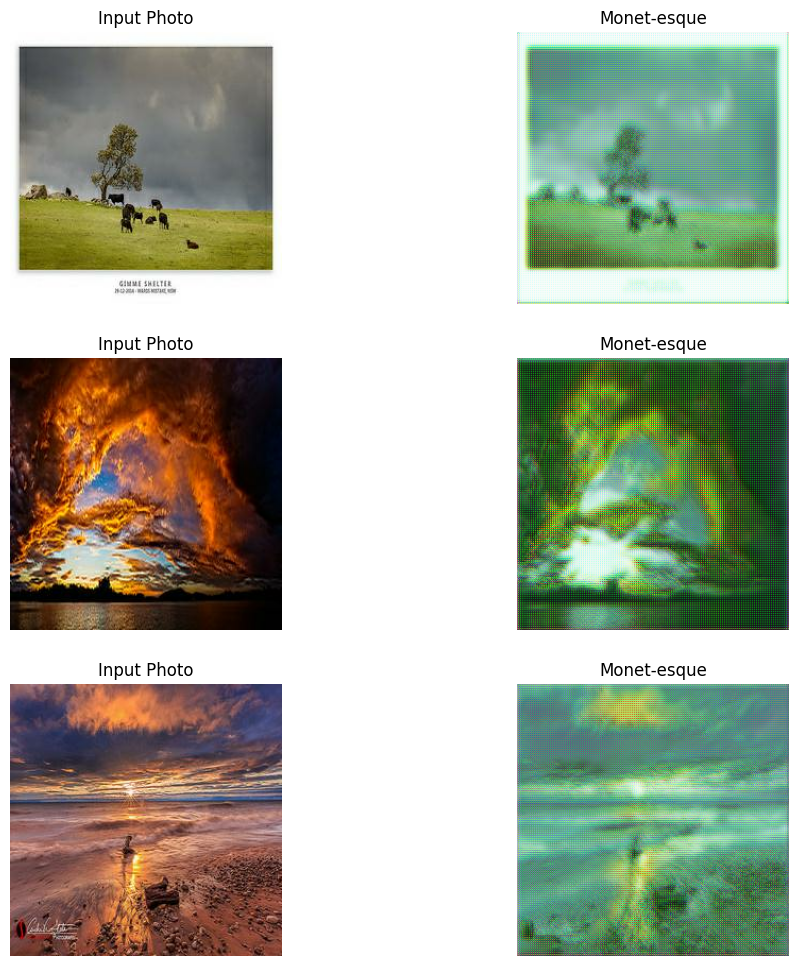

In [10]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(3)):
    prediction = cycle_gan.models["generator_G"](img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

<a id="conclusion"></a>
# **6- Conclusion**

Since I only had my own personal computer to use, I had to simplify the model so that the training could be carried out. I have simplified generator and discriminator models by reducing the number of filters, residual blocks, and upsampling layers. This will lower the computational cost while maintaining reasonable performance. 

We can find that Model 1 (learning_rate=0.0002) is stable, shows gradual improvements, and maintains a balance between generator and discriminator. Training can continue for more epochs for better results.

<a id=submission></a>
# **7- Submission**

In [19]:
# Ensure the images directory exists
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

# Save generated images
for i, img in enumerate(photo_ds, start=1):
    prediction = cycle_gan.models["generator_G"](img, training=False)[0].numpy()
    prediction = np.clip((prediction * 127.5 + 127.5), 0, 255).astype(np.uint8)  # Ensure valid pixel range
    im = PIL.Image.fromarray(prediction)
    image_path = os.path.join(output_dir, f"{i}.jpg")
    im.save(image_path)
    print(f"Saved: {image_path}")

# Create a zip archive of the images directory
shutil.make_archive(output_dir, 'zip', output_dir)
print(f"Created ZIP archive: {output_dir}.zip")


Saved: images\1.jpg
Saved: images\2.jpg
Saved: images\3.jpg
Saved: images\4.jpg
Saved: images\5.jpg
Saved: images\6.jpg
Saved: images\7.jpg
Saved: images\8.jpg
Saved: images\9.jpg
Saved: images\10.jpg
Saved: images\11.jpg
Saved: images\12.jpg
Saved: images\13.jpg
Saved: images\14.jpg
Saved: images\15.jpg
Saved: images\16.jpg
Saved: images\17.jpg
Saved: images\18.jpg
Saved: images\19.jpg
Saved: images\20.jpg
Saved: images\21.jpg
Saved: images\22.jpg
Saved: images\23.jpg
Saved: images\24.jpg
Saved: images\25.jpg
Saved: images\26.jpg
Saved: images\27.jpg
Saved: images\28.jpg
Saved: images\29.jpg
Saved: images\30.jpg
Saved: images\31.jpg
Saved: images\32.jpg
Saved: images\33.jpg
Saved: images\34.jpg
Saved: images\35.jpg
Saved: images\36.jpg
Saved: images\37.jpg
Saved: images\38.jpg
Saved: images\39.jpg
Saved: images\40.jpg
Saved: images\41.jpg
Saved: images\42.jpg
Saved: images\43.jpg
Saved: images\44.jpg
Saved: images\45.jpg
Saved: images\46.jpg
Saved: images\47.jpg
Saved: images\48.jpg
S

<a id="ref"></a>
# **8- References**

- https://www.kaggle.com/competitions/gan-getting-started
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
- https://www.kaggle.com/code/hejuncheung/painter-myself-simple-gan